In [ ]:
!pip install torchdiffeq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(str(device) + ' is being used...')

cuda is being used...


# Solvers

In [ ]:
def euler(func, t, dt, y):
  return dt * func(t, y)

In [ ]:
def rk4(func, t, dt, y):
  one_sixth = 1/6
  half_dt = dt * 0.5

  k1 = func(t, y)
  k2 = func(t + half_dt, y + half_dt * k1)
  k3 = func(t + half_dt, y + half_dt * k2)
  k4 = func(t + dt, y + dt * k3)

  return (k1 + 2 * (k2 + k3) + k4) * dt * one_sixth

In [ ]:
class NeuralODE(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, y0, t, solver):
    solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-2], t[1:]):
      dy = solver(self.func, t0, t1 - t0, y0)
      y1 = y0 + dy
      solution[j] = y1
      j += 1
      y0 = y1
    return solution

# ODE Models

In [ ]:
class ODEFuncTanh(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(1, 50),
                             nn.Tanh(),
                             nn.Linear(50, 1))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

In [ ]:
class ODEFuncSig(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 50),
                             nn.Sigmoid(),
                             nn.Linear(50, 2))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

In [ ]:
class ODEFuncReLU(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 50),
                             nn.ReLU(),
                             nn.Linear(50, 50),
                             nn.ReLU(),
                             nn.Linear(50, 2))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

In [ ]:
class SinAct(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class ODEFuncSinAct(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 50),
                             SinAct(),
                             nn.Linear(50, 2))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

#Spring Mass Function
F = -kx

In [ ]:
F = 90 # (40√5 ~ 89.4)
mass = 2.0
x = 5.0
k = 2.0
v = 0.0

In [ ]:
# Computing True Value
data_size = 5000
tensor1 = torch.tensor([[x, v]]).cuda()
t = torch.linspace(0., 100., data_size).cuda()
tensor2 = torch.tensor([[0.0, 1.0], [-k/mass, 0.0]]).cuda()
tensor2 = tensor2.transpose(0, 1)
print(tensor2)
print(tensor1.shape, tensor2.shape)

class Lambda(nn.Module):
  def forward(self, t, y):
    return torch.mm(y, tensor2)

with torch.no_grad():
  true_y = odeint_adjoint(func = Lambda(), y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
  print(true_y)

In [ ]:
# Visualizing
def visualize(true_y, pred_y=None):

  fig = plt.figure(figsize = (10, 10))
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.set_title('x vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'green', label='true trajectory')

  ax2 = fig.add_subplot(2, 1, 2)
  ax2.set_title('v vs. t')
  ax2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')

  if pred_y is not None:
    ax1.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], 'red', label='prediction')
    ax2.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'red', label='prediction')

  # ax.set_xlim(-5.5, 5.5)
  # ax.set_ylim(-5.5, 5.5)
  plt.legend()
  plt.grid(True)
  plt.show()

visualize(true_y)

In [ ]:
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

In [ ]:
from torchdiffeq import odeint_adjoint

niters = 400

func = ODEFuncSinAct().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
end_time = time.time()
time_required = end_time - start_time
print('Process Time: {} secs'.format(time_required))

In [ ]:
# Visualing the Predictions
with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

# Cos Function

In [ ]:
y0 = torch.Tensor([[0]]).cuda()
t = torch.linspace(0., 6*np.pi, 1500).cuda()

class cos(nn.Module):
  def forward(self, t, y):
    return torch.cos(t) * torch.exp(-0.05*t) + torch.tensor(1)

true_y = odeint_adjoint(func = cos(), y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')

# ***** Visualing *****
def visualize(true_y, pred_y=None):
  fig = plt.figure(figsize = (10, 10))
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.set_title('x vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], 'green', label='true trajectory')

  if pred_y is not None:
    print(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0])
    print(t.cpu().numpy().shape, pred_y.cpu().detach().numpy()[:, 0].shape)
    ax1.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:100, 0], 'red', label='prediction')

  plt.legend()
  plt.grid(True)
  plt.show()

# ***** Training *****
data_size = 1510
batch_time = 100
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

niters = 500

func = ODEFuncTanh().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()
  if iter%20 == 0:
    print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
    print(pred_y)
    visualize(true_y, pred_y)

# Transposing the result
#test_result = test_result.transpose(0, 1)

with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))

In [ ]:
with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

# Exponential Function

In [ ]:
data_size = 1500
y0 = torch.Tensor([[10]]).cuda()
t = torch.linspace(0., 100., data_size).cuda()

class exponent(nn.Module):
  def forward(self, t, y):
    return -0.05 * y

true_y = odeint_adjoint(func = exponent(), y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')

# ***** Visualing *****
def visualize(true_y, pred_y=None):
  fig = plt.figure(figsize = (10, 10))
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.set_title('x vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], 'green', label='true trajectory')

  if pred_y is not None:
    # print(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0])
    # print(t.cpu().numpy().shape, pred_y.cpu().detach().numpy()[:, 0].shape)
    ax1.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 0], 'red', label='prediction')

  plt.legend()
  plt.grid(True)
  plt.show()

# ***** Training *****
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

niters = 500

func = ODEFuncTanh().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()
  if iter%20 == 0:
    print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
    # print(pred_y)
    # visualize(true_y, pred_y)

# Transposing the result
#test_result = test_result.transpose(0, 1)

with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    # visualize(true_y, pred_y)

print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))

  0%|          | 0/501 [00:00<?, ?it/s]

Iter 0000 | Total Loss 0.016732
Iter 0020 | Total Loss 0.004400
Iter 0040 | Total Loss 0.001999
Iter 0060 | Total Loss 0.003895
Iter 0080 | Total Loss 0.002599
Iter 0100 | Total Loss 0.002525
Iter 0120 | Total Loss 0.005812
Iter 0140 | Total Loss 0.005767
Iter 0160 | Total Loss 0.002082
Iter 0180 | Total Loss 0.002300
Iter 0200 | Total Loss 0.001745
Iter 0220 | Total Loss 0.002268
Iter 0240 | Total Loss 0.008134
Iter 0260 | Total Loss 0.001165
Iter 0280 | Total Loss 0.001783
Iter 0300 | Total Loss 0.003154
Iter 0320 | Total Loss 0.001164
Iter 0340 | Total Loss 0.001512
Iter 0360 | Total Loss 0.002478
Iter 0380 | Total Loss 0.001061
Iter 0400 | Total Loss 0.000841
Iter 0420 | Total Loss 0.000584
Iter 0440 | Total Loss 0.002043
Iter 0460 | Total Loss 0.003443
Iter 0480 | Total Loss 0.004028
Iter 0500 | Total Loss 0.003751
Iter 0500 | Total Loss 0.003751


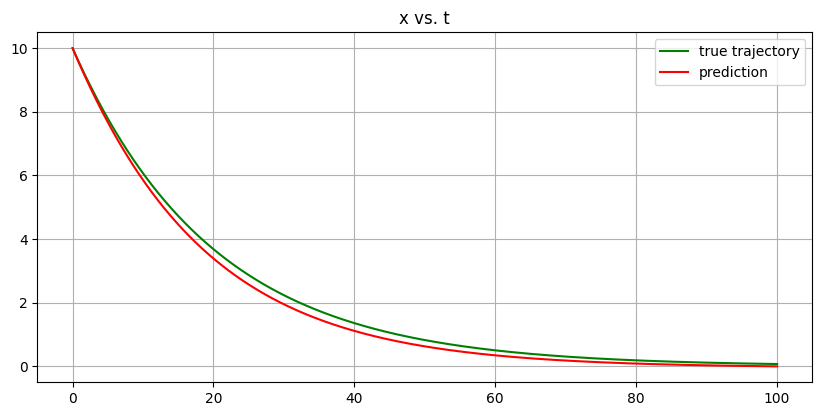

In [ ]:
with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

# 2nd Order Differential Equation - Part 1

In [ ]:
eta = 0.0   # 0 < eta < 1
wn = 1.0
U = 1.0

x1 = 0.0
x2 = 0.0

In [ ]:
# Computing True Value
data_size = 5000
tensor1 = torch.tensor([[x1, x2]]).cuda()
t = torch.linspace(0.0, 100.0, data_size).cuda()
tensor2 = torch.tensor([[0.0, 1.0], [-1*(wn**2), -2*(eta)*wn]]).cuda()
tensor2 = tensor2.transpose(0, 1)
print(tensor2)
print(tensor1.shape, tensor2.shape)

class Lambda(nn.Module):
  def forward(self, t, y):
    mulMat = torch.mm(y, tensor2)
    tensor3 = torch.tensor([[0.0, wn**2]]).cuda()
    return mulMat+tensor3

with torch.no_grad():
  true_y = odeint_adjoint(func = Lambda(), y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
  print(true_y)

tensor([[ 0., -1.],
        [ 1., -0.]], device='cuda:0')
torch.Size([1, 2]) torch.Size([2, 2])
tensor([[[ 0.0000e+00,  0.0000e+00]],

        [[ 2.0007e-04,  2.0003e-02]],

        [[ 8.0021e-04,  3.9997e-02]],

        ...,

        [[ 1.5863e-01, -5.4045e-01]],

        [[ 1.4798e-01, -5.2351e-01]],

        [[ 1.3768e-01, -5.0636e-01]]], device='cuda:0')


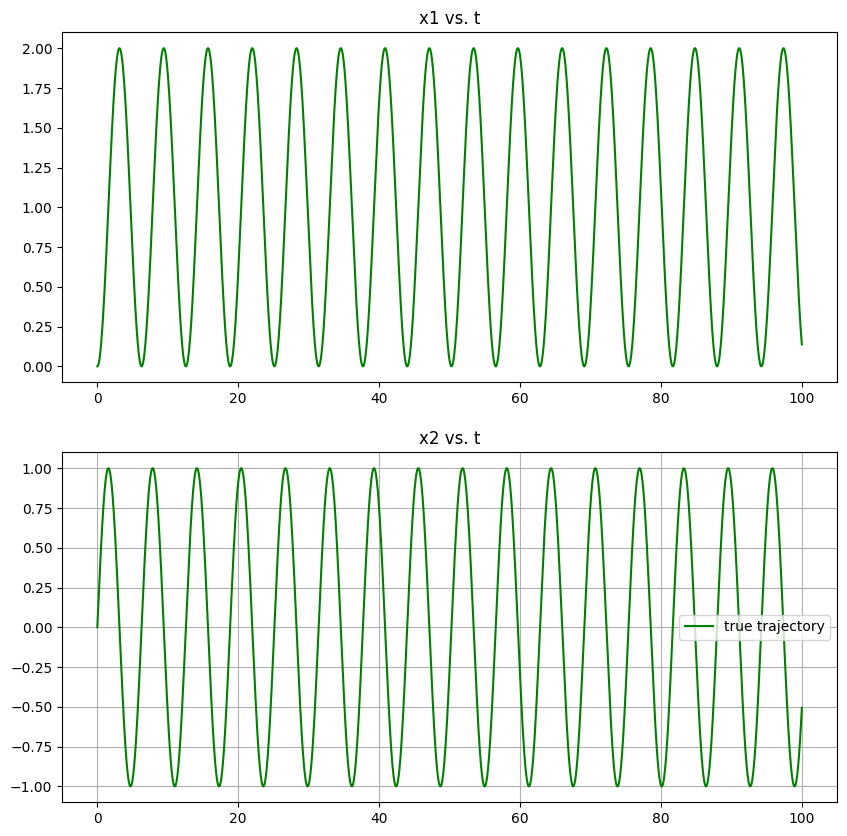

In [ ]:
# Visualizing
def visualize(true_y, pred_y=None):

  fig = plt.figure(figsize = (10, 10))
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.set_title('x1 vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'green', label='true trajectory')

  ax2 = fig.add_subplot(2, 1, 2)
  ax2.set_title('x2 vs. t')
  ax2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')

  if pred_y is not None:
    ax1.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], 'red', label='prediction')
    ax2.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'red', label='prediction')

  # ax.set_xlim(-5.5, 5.5)
  # ax.set_ylim(-5.5, 5.5)
  plt.legend()
  plt.grid(True)
  plt.show()

visualize(true_y)

In [ ]:
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

In [ ]:
from torchdiffeq import odeint_adjoint

niters = 700

func = ODEFuncTanh().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
end_time = time.time()
time_required = end_time - start_time
print('Process Time: {} secs'.format(time_required))

  0%|          | 0/701 [00:00<?, ?it/s]

Iter 0700 | Total Loss 0.000496
Process Time: 139.59656715393066 secs


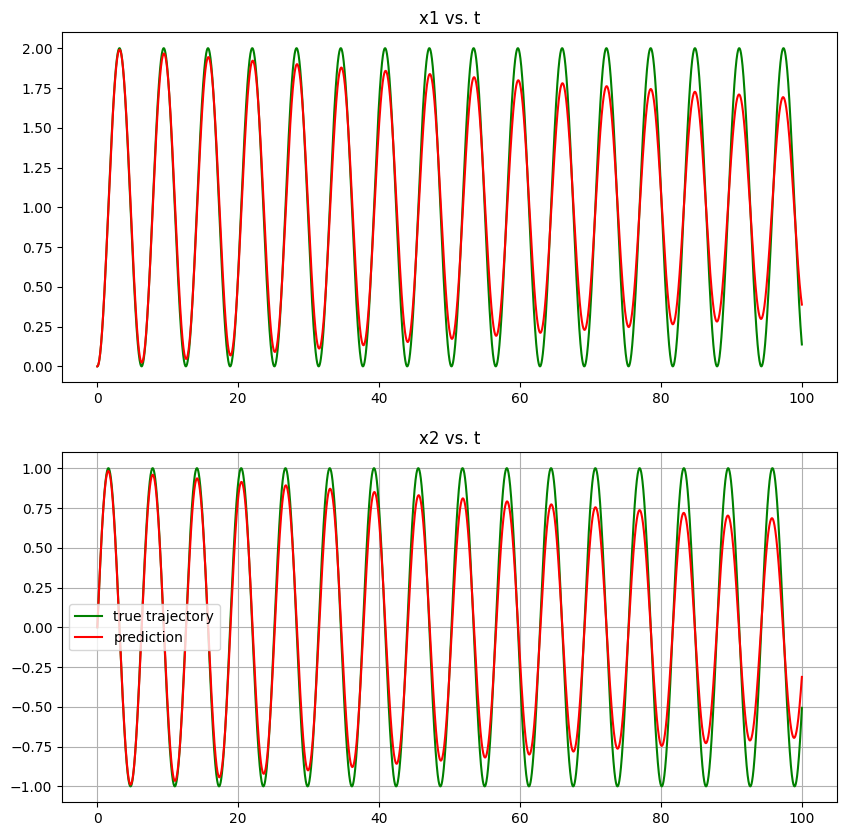

In [ ]:
# Visualing the Predictions
with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

# 2nd Order Differential Equations - Part 2

In [ ]:
U = 1.0
x1 = 0.0
x2 = 0.0
tensor2 = torch.empty(0, 2, 2).cuda()

eta = torch.linspace(0.0, 5.0, steps=32).cuda()
# wn = torch.linspace(0, 2*np.pi, steps=32).cuda()
wn = 1.0
# print(eta.shape, wn.shape)

data_size = 1000
tensor1 = torch.tensor([[x1, x2]]).cuda()
t = torch.linspace(0.0, 100.0, data_size).cuda()

# Computing True Value
for i in range(0, 32):
    tensori = torch.tensor([[0.0, 1.0], [-1*(wn**2), -2*(eta[i])*wn]]).cuda()
    tensori = tensori.transpose(0, 1).unsqueeze(0)
    tensor2 = torch.cat([tensor2, tensori], dim=0)

# print(tensor2)
print(tensor1.shape, tensor2.shape)

class Lambda(nn.Module):
    def __init__(self, i):
        super().__init__()
        global tensor2, wn
        self.tensor2 = tensor2[i]
        self.wn = wn

    def forward(self, t, y):
        a = torch.mm(y, self.tensor2) + torch.tensor([[0.0, self.wn**2]]).cuda()
        return a

# Visualizing
def visualize(true_y, pred_y=None):

  fig = plt.figure(figsize = (10, 10))
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.set_title('x1 vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'green', label='true trajectory')

  ax2 = fig.add_subplot(2, 1, 2)
  ax2.set_title('x2 vs. t')
  ax2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')

  if pred_y is not None:
    ax1.plot(t.cpu().detach().numpy(), pred_y.cpu().detach().numpy()[:, 0, 0], 'red', label='prediction')
    ax2.plot(t.cpu().detach().numpy(), pred_y.cpu().detach().numpy()[:, 0, 1], 'red', label='prediction')

  # ax.set_xlim(-5.5, 5.5)
  # ax.set_ylim(-5.5, 5.5)
  plt.legend()
  plt.grid(True)
  plt.show()

true_y = torch.empty(0, data_size, 1, 2).cuda()
true_eta = torch.empty(0).cuda()
with torch.no_grad():
    for i in range(32):
        true_i = odeint_adjoint(func = Lambda(i), y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5').unsqueeze(0)
        true_y = torch.cat((true_y, true_i), 0)
        # true_eta = torch.cat((true_eta, torch.ones(data_size).cuda()*eta[i]))
        # visualize(true_y)

# visualize(true_y)

torch.Size([1, 2]) torch.Size([32, 2, 2])


In [ ]:
batch_time = 10
batch_size = 16

def get_batch():
  randInt = np.random.randint(0, 32)
  chunk = true_y[randInt]
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = chunk[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_t = torch.cat((batch_t, eta[randInt].unsqueeze(0)))
  batch_y = torch.stack([chunk[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  #print(eta.shape)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

from torchdiffeq import odeint_adjoint

niters = 1000

func = ODEFuncReLU().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()

  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()
  if iter%50 == 0:
    with torch.no_grad():
        pred_y = odeint_adjoint(func = func, y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
        # visualize(true_y, pred_y)

print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
end_time = time.time()
time_required = end_time - start_time
print('Process Time: {} secs'.format(time_required))

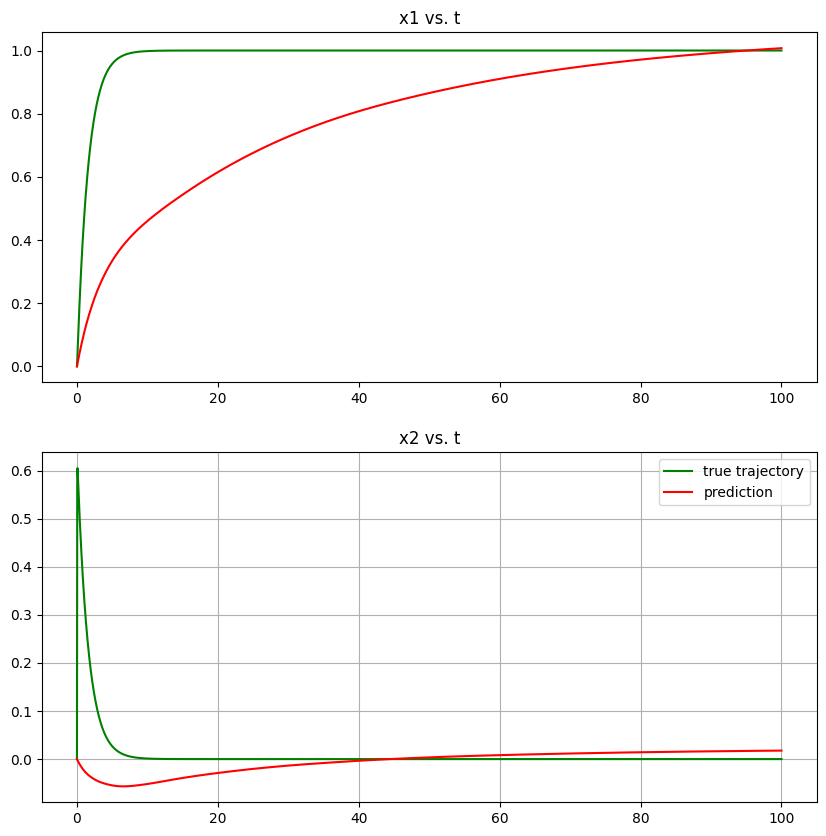

In [ ]:
# Visualing the Predictions
with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

In [ ]:
print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
end_time = time.time()
time_required = end_time - start_time
print('Process Time: {} secs'.format(time_required))

Iter 1000 | Total Loss 0.213396
Process Time: 436.6692388057709 secs
